# Life Expectancy Estimation (ML modeling)

## Goal

This is the second notebook, we are going to carry on our work, after explaining the data, we are going to build a model to predict the life expectancy of a country.

## Data

We are going to use the data we have already cleaned in the previous notebook. We saved the dataset as a csv file `../data/processed/life_expectancy.csv`.

## Analysis

We will first process with:

1. Feature engineering
2. Preprocessing
3. Modeling
4. Evaluation

## Import libraries and Load Data



In [43]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5, 5)

In [44]:
# load data
df = pd.read_csv('../data/processed/life_expectancy.csv')

## Feature Engineering

In this section, we are going to create a set of new features, and drop the ones we don't need.

Let's start with the ones we are going to drop:

- `country` - this feature has many classes, which are already grouped in the `Region` feature, so we don't need it.
- `year` - this feature is not useful for our model, because we are going to predict the life expectancy for a country in the future, so we don't need it. One more thing is that logically, a year couldn't have impact on the lifespan, it's just that throughout the years, with the economic and technical progress that facilitates people's lives and improves their health, the life expectancy increases.
- `population_mln` - this feature doesn't impact the lifespan, it's just the population of the country.

These features could be dropped without being questioned, because we have cutting clear evidence for that.

In [45]:
# drop irrelevant columns
df.drop(['country', 'year', 'population_mln'], axis=1, inplace=True)

Now, let's talk about the different that we need to transform:

- We said that `bmi` could be grouped into categories, we mean the 4 categories that are defined below
    - bmi < 18.5: Underweight
    - bmi >= 18.5 and bmi < 25: Normal
    - bmi >= 25 and bmi < 30: Overweight
    - bmi >= 30: Obese
- `infant_death`, `kid_death` and `adult_death` could be combined into one feature, `mortality_rate`, which is the central value of these three features, depending on the distribution of the data.
- `hepatitis_b`, `polio` and `diphtheria` could be combined into one feature, `vaccination_rate`, which is the central value of these three features, depending on the distribution of the data, note that we have not used `measles` because its distribution differs from the first three, adding the fact that there was no clear evidence that it impacts the life expectancy, nor the other three features.
- `thinness_kid` and `thinness_teen` could be combined into one feature, `thinness_rate`, which is the central value of these two features, depending on the distribution of the data.

In [46]:
# group bmi
df['bmi_group'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 100], labels=['underweight', 'normal', 'overweight', 'obese'])
df.head()

,region,infant_deaths,kid_deaths,adult_deaths,alcohol,hepatitis_b,measles,bmi,polio,diphtheria,incidents_hiv,income,thinness_teen,thinness_kid,schooling,lifespan,status,bmi_group
0,Middle East,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,4.9,4.8,7.8,76.5,developing,overweight
1,European Union,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,0.6,0.5,9.7,82.8,developed,overweight
2,Asia,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,27.1,28.0,5.0,65.4,developing,normal
3,South America,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,5.7,5.5,7.9,67.0,developing,overweight
4,Middle East,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,1.2,1.1,12.8,81.7,developed,overweight


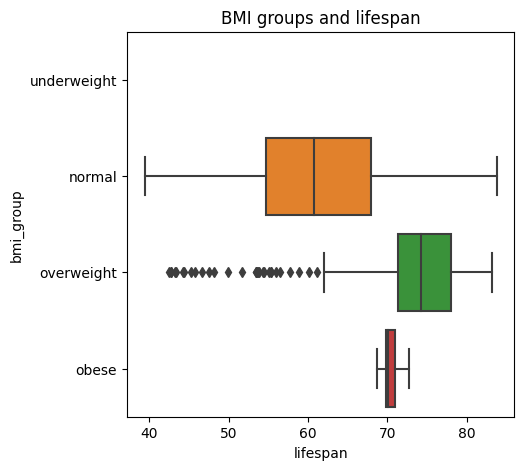

In [47]:
# bmi groups and lifespan
sns.boxplot(data=df, x='lifespan', y='bmi_group')
plt.title('BMI groups and lifespan')
plt.show()

Here we see that these boxplots are overlapping, but we see a difference in terms of the central tendancy for the 3 classes, there is also a huge difference in terms of the spread, meaning that there is a difference between these groups, an entry with an obese bmi category will have its lifespan to be very close to 70 years, and when we move from a class to another, the probability of having a certain lifespan differs.  
It is not surely that we'll get a better result using this category instead of the original feature, but we'll see.

Now let's work on grouping mortality rates, immunization rates and thinness rates.

- We saw on the analysis that `infant_death`, `kid_death` and `adult_death` are highly correlated with each other, let's look at their distributions.

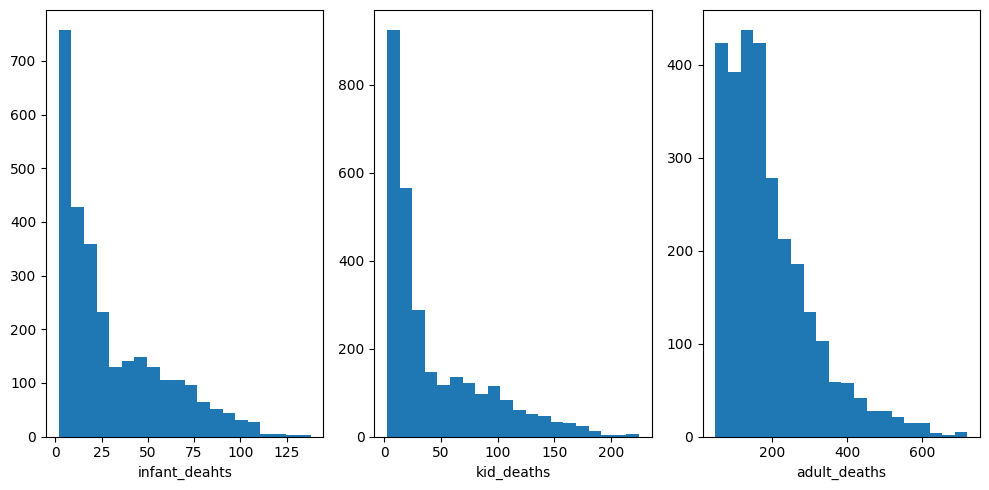

In [48]:
# histograms of mortality rates
# create figure
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# plot histograms
ax[0].hist(df['infant_deaths'], bins=20)
ax[1].hist(df['kid_deaths'], bins=20)
ax[2].hist(df['adult_deaths'], bins=20)

# adjust the plot
ax[0].set_xlabel('infant_deahts')
ax[1].set_xlabel('kid_deaths')
ax[2].set_xlabel('adult_deaths')
plt.tight_layout()
plt.show()

- We see that the 3 distributions are right skewed, we can take the mean of the 3 features to create a new feature, and we'll look at its distribution to see if it preserves the same common properties.

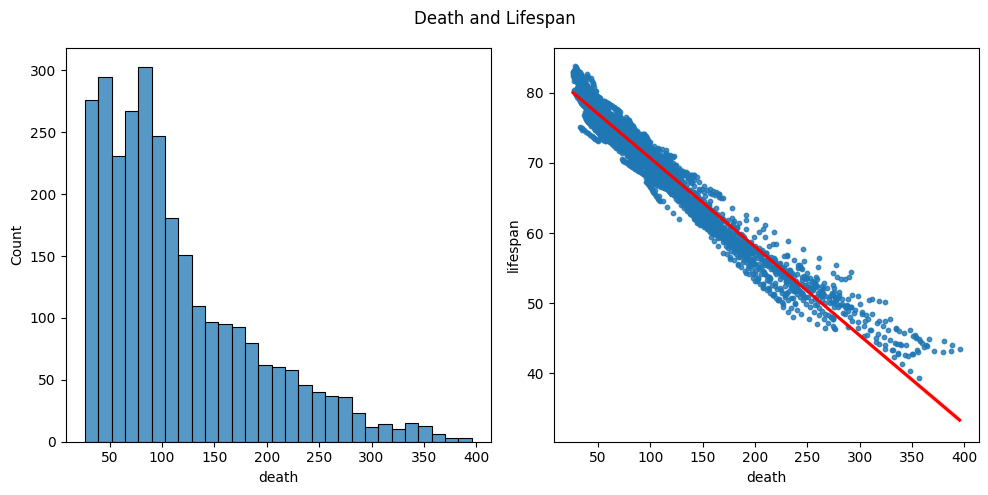

In [49]:
# create deaths column
df['death'] = df['infant_deaths']*0.25 + df['kid_deaths']*0.25 + df['adult_deaths']*0.5

# visualize the new column
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram and scatter plot
sns.histplot(data=df, x='death', ax=ax[0])
sns.regplot(data=df, x='death', y='lifespan', scatter_kws={'s':10}, line_kws={'color':'red'}, ax=ax[1])

# adjust the plot
plt.suptitle('Death and Lifespan')
plt.tight_layout()
plt.show()

- We see that the newly created feature preserves the linear association with the target, and its distribution is also right skewed, as the original features, this could serve as a valid feature for our model.
- Note that in the formula, we gave more weight to adult deaths, this is because in most cases, adults constitute a larger part of the population.

Now we need to see if we can do the same for the immunization rates.  
In the first notebook, we saw how hepatitis_b, polio and diphtheria are highly correlated with each other, and they follow the same distribution, and we saw that measles isn't associated with them, and it doesn't seem to impact the life expectancy much.  
Let us create one feature called `immunization`, which holds the mean of the three columns.

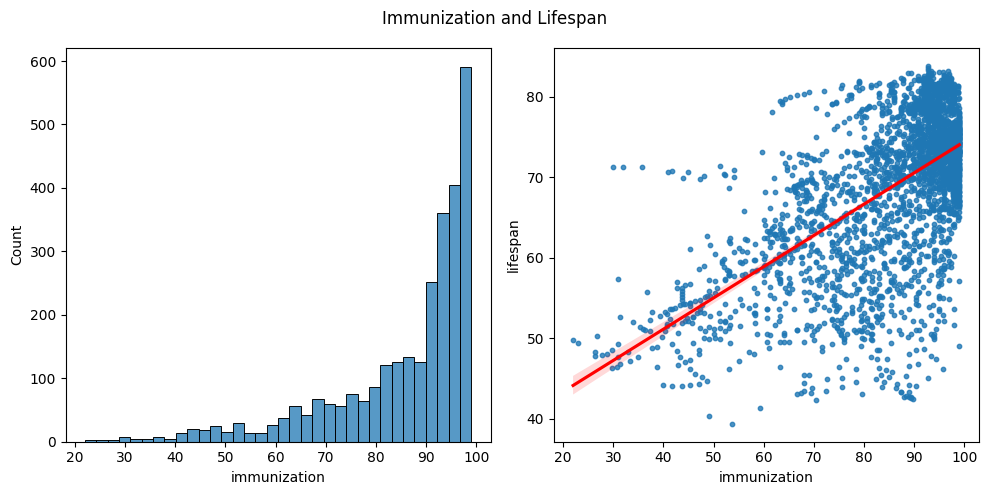

In [50]:
# create immunization feature
df['immunization'] = (df['hepatitis_b'] + df['polio'] + df['diphtheria']) / 3

# visualize the new column
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram and scatter plot
sns.histplot(data=df, x='immunization', ax=ax[0])
sns.regplot(data=df, x='immunization', y='lifespan', scatter_kws={'s':10}, line_kws={'color':'red'}, ax=ax[1])

# adjust the plot
plt.suptitle('Immunization and Lifespan')
plt.tight_layout()
plt.show()

- Here again, the dsitribution follows the same pattern as the original marginal distributions, and the relationship with lifespan is preserved, this is a valid feature.

Now, thinness is the only thing left, due to the perfect correlation between kids and teens thinness, we can either drop one column, or let us just do the same here and create a new column with the mean of two.

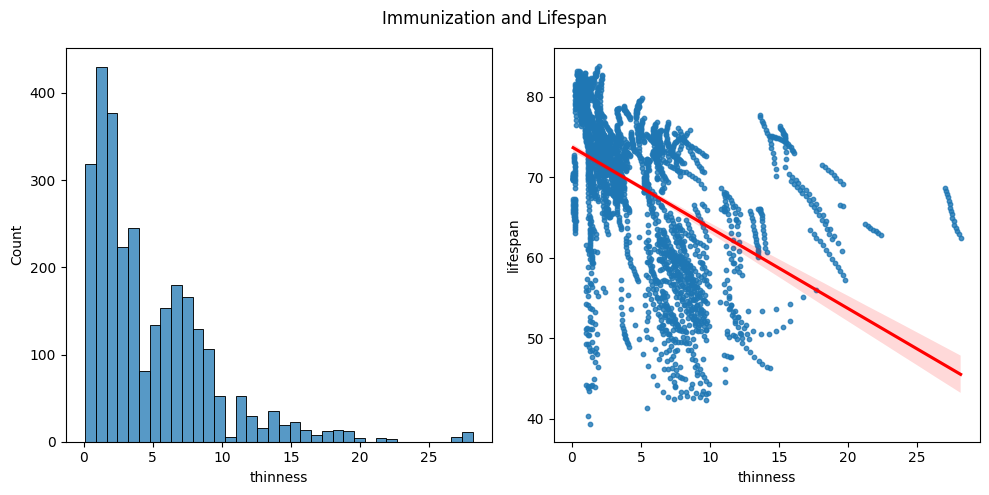

In [51]:
# create thinness feature
df['thinness'] = (df['thinness_kid'] + df['thinness_teen']) / 2

# visualize the new column
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram and scatter plot
sns.histplot(data=df, x='thinness', ax=ax[0])
sns.regplot(data=df, x='thinness', y='lifespan', scatter_kws={'s':10}, line_kws={'color':'red'}, ax=ax[1])

# adjust the plot
plt.suptitle('Immunization and Lifespan')
plt.tight_layout()
plt.show()

Once again, this is a valid column, since the distribution is respected as well as the relationship with lifespan. However, the relationship between this feature and lifespan isn't convincing, we'll see if it's useful or not.

Now we don't know what to do with the status column, should we drop it or keep it?  
We might think at a glance that this category might be associated with the region, let's assume that this is the case, and we'll see if it's true, using the following chi square test.

In [52]:
# chi2 of region and status
from scipy.stats import chi2_contingency

# create contingency table
Xtab = pd.crosstab(df['region'], df['status'])

# chi2 test
chi2, p, dof, expected = chi2_contingency(Xtab)

# print results
print(Xtab)
print('chi2: ', chi2, 'p: ', p)

status                         developed  developing
region                                              
Africa                                 0         816
Asia                                  16         416
Central America and Caribbean          0         304
European Union                       432           0
Middle East                           16         208
North America                         32          16
Oceania                               32         144
Rest of Europe                        64         176
South America                          0         192
chi2:  2168.499487744558 p:  0.0


The contingency table is as follows:
- When we mention North America and the European Union, we see countries that are classified with a status of developed, on the other hand we talk about regions like - Africa, Asia, Central America, Middle East, Oceania, South America and the rest of Europ, we talk about developing countries, hence the very high statistique of the chi-square test or the low p-value, we can surely drop the status or the region. It might be wiser to drop region as it is the one with many classes and not all the classes differ from each others, as we saw in the analysis.

Before dropping the original features, which we used for creating the new ones, let's use them in a model, just to see if we have made a wise decision or not.  
For now, the feature that are convincing are `region`, `income`, `schooling`, `bmi_group`, `death` and `immunization`.  
The features that are ambiguous are `thinness`, `incidents_hiv`, `alcohol`, and `measles`.

## Preprocessing

Before we start modeling, we need to preprocess our data, due to the different scales and the skewed distributions.

In [53]:
df.columns

Index(['region', 'infant_deaths', 'kid_deaths', 'adult_deaths', 'alcohol',
       'hepatitis_b', 'measles', 'bmi', 'polio', 'diphtheria', 'incidents_hiv',
       'income', 'thinness_teen', 'thinness_kid', 'schooling', 'lifespan',
       'status', 'bmi_group', 'death', 'immunization', 'thinness'],
      dtype='object')